# Discrete Wavelet Transform (DWT) on CWRU Bearing Data

**Datasets** : CWRU bearing vibration data (Normal_0 vs IR007_0)


## 1. Import libraries

In [1]:
import numpy as np
import scipy.io as sio
import pywt
import matplotlib.pyplot as plt

## 2. Load CWRU vibration signal

In [2]:
def load_cwru_signal(mat_path, signal_key, length=4096):
    mat = sio.loadmat(mat_path)
    signal = mat[signal_key].squeeze()
    signal = signal[:length]
    signal = (signal - np.mean(signal)) / np.std(signal)
    return signal

Now load both conditions:

In [3]:
normal_signal = load_cwru_signal(
    'datasets/cwru/Normal_0.mat',
    'X097_DE_time'                   # 'X097_DE_time', 'X097_FE_time', 'X097RPM'
)

ir007_signal = load_cwru_signal(
    'datasets/cwru/IR007_0.mat',
    'X105_DE_time'                  # 'X105_DE_time', 'X105_FE_time', 'X105_BA_time', 'X105RPM'
)

## 3. Original signals (time domain)

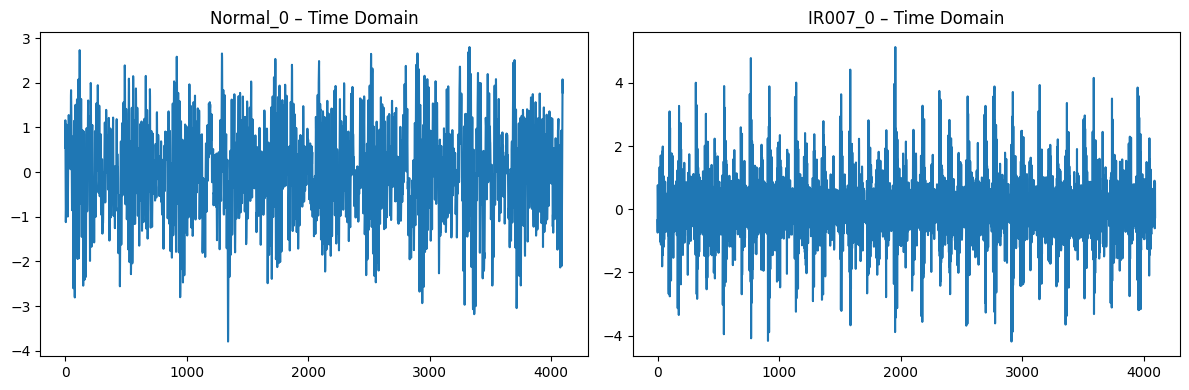

In [4]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(normal_signal)
plt.title('Normal_0 – Time Domain')

plt.subplot(1,2,2)
plt.plot(ir007_signal)
plt.title('IR007_0 – Time Domain')

plt.tight_layout()
plt.show()

## 4. Boundary Padding
**Why padding is required**
- DWT is implemented using convolution
- Convolution requires signal samples beyong the edges
- Real signal are finite -> edges cause distortion

**What padding does**
- Extends the signal at both ends
- Prevents artificial discontinuities

**Common padding modes**
- Symmetric : Mirror the signal (most stable)
- Periodic : Assume signal repeats
- Zero : Pad with zeros (can create artifacts)

In [5]:
mode = 'symmetric'

### 4.1. Boundary Padding Visualization (Optional)

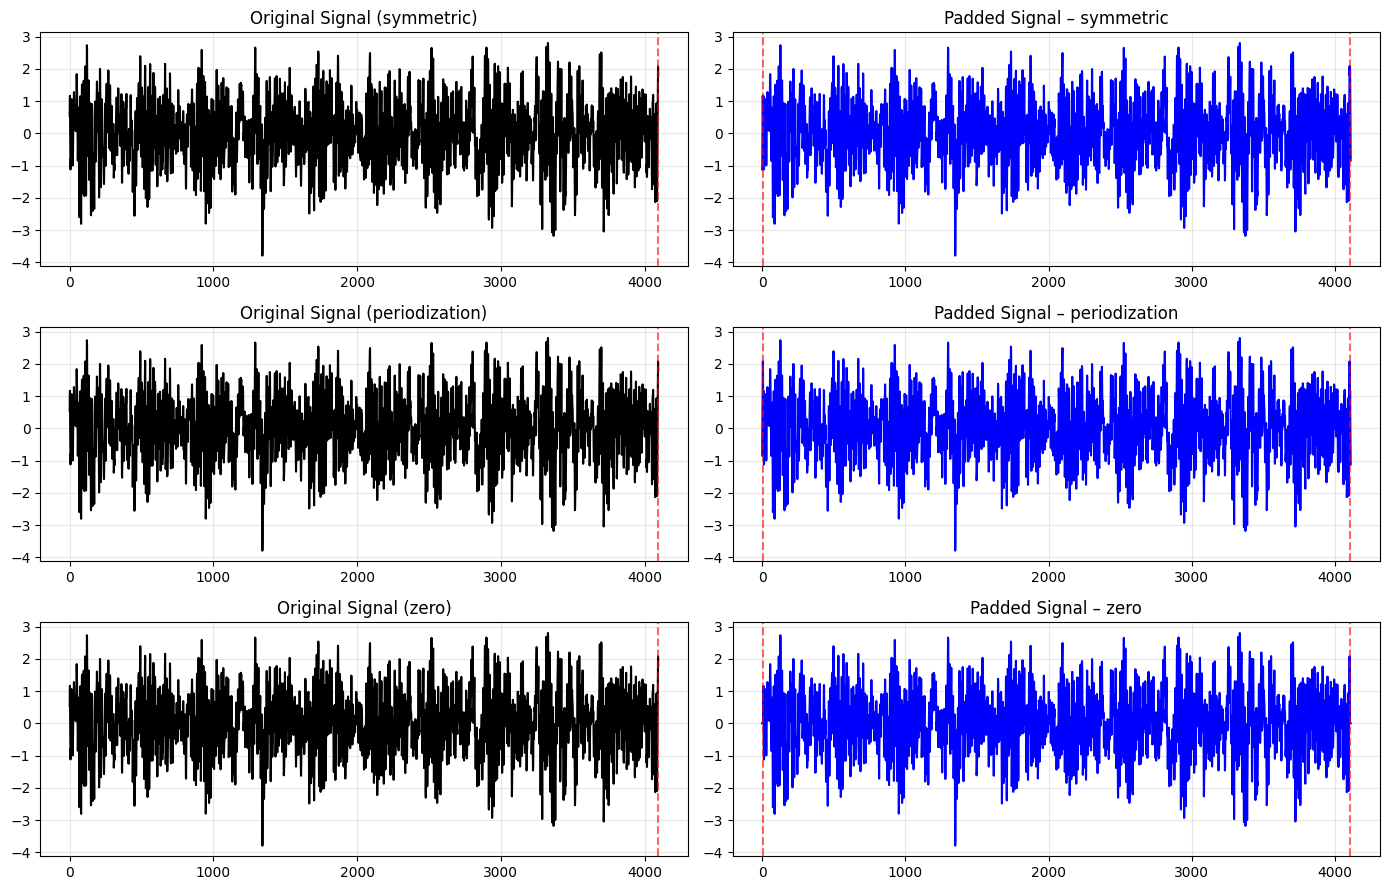

In [6]:
wavelet = 'db4'
modes = ['symmetric', 'periodization', 'zero']

signal = normal_signal   # or ir007_signal
filter_len = pywt.Wavelet(wavelet).dec_len

plt.figure(figsize=(14, 9))

for i, m in enumerate(modes):

    # Padding length required by DWT
    pad_len = filter_len - 1

    # Apply padding explicitly
    padded_signal = pywt.pad(signal, pad_len, mode=m)

    # Plot original signal
    plt.subplot(3, 2, 2*i + 1)
    plt.plot(signal, color='black')
    plt.title(f'Original Signal ({m})')
    plt.axvline(len(signal), linestyle='--', color='red', alpha=0.6)
    plt.grid(alpha=0.3)

    # Plot padded signal
    plt.subplot(3, 2, 2*i + 2)
    plt.plot(padded_signal, color='blue')
    plt.title(f'Padded Signal – {m}')
    plt.axvline(pad_len, linestyle='--', color='red', alpha=0.6)
    plt.axvline(len(signal) + pad_len, linestyle='--', color='red', alpha=0.6)
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Wavelet Selection (Filter Choice)
In DWT, the wavelet determines the shape and length of the analysis filters used for signal decomposition.

**Why it matters**
- Different wavelets act as different filter banks
- The wavelet affect
    - Time localization
    - Frequency localization
    - Sensitivity to impulsive events

**Commonly Used Wavelets in DWT**
| Wavelet   | Family           | Filter Length | Key Characteristics |
|-----------|------------------|---------------|---------------------|
| `haar`    | Haar             | 2             | Very simple, blocky, poor frequency resolution |
| `db2`     | Daubechies       | 4             | Sharp impulse response, sensitive to noise |
| `db4`     | Daubechies       | 8             | Balanced time–frequency resolution, compact support |
| `db8`     | Daubechies       | 16            | Smoother, better frequency resolution |
| `sym4`    | Symlet           | 8             | Nearly symmetric, low phase distortion |
| `sym8`    | Symlet           | 16            | Smoother than sym4 |
| `coif3`   | Coiflet          | 18            | Good time–frequency balance, more vanishing moments |
| `coif5`   | Coiflet          | 30            | Excellent frequency localization |
| `bior3.5` | Biorthogonal     | 18 / 10       | Linear phase, symmetric |
| `rbio3.5` | Biorthogonal     | 10 / 18       | Linear phase inverse | 
| `dmey`    | Discrete Meyer   | Long          | Very smooth frequency response |  

In [7]:
wavelet = 'db4'

## 6. Single-level DWT
A single-level DWT decomposes a signal into approximation and detail components using low-pass and high-pass filtering followed by downsampliing

**Mathematical idea**
- Apply low-pass filter -> extract slow variation
- Apply high-pass filter -> extract rapid changes
- Downsample by 2 -> remove redundancy

**Output**
- `cA1`: Approximation coefficients (low frequency)
- `cD1`: Detail coefficients (high frequency)

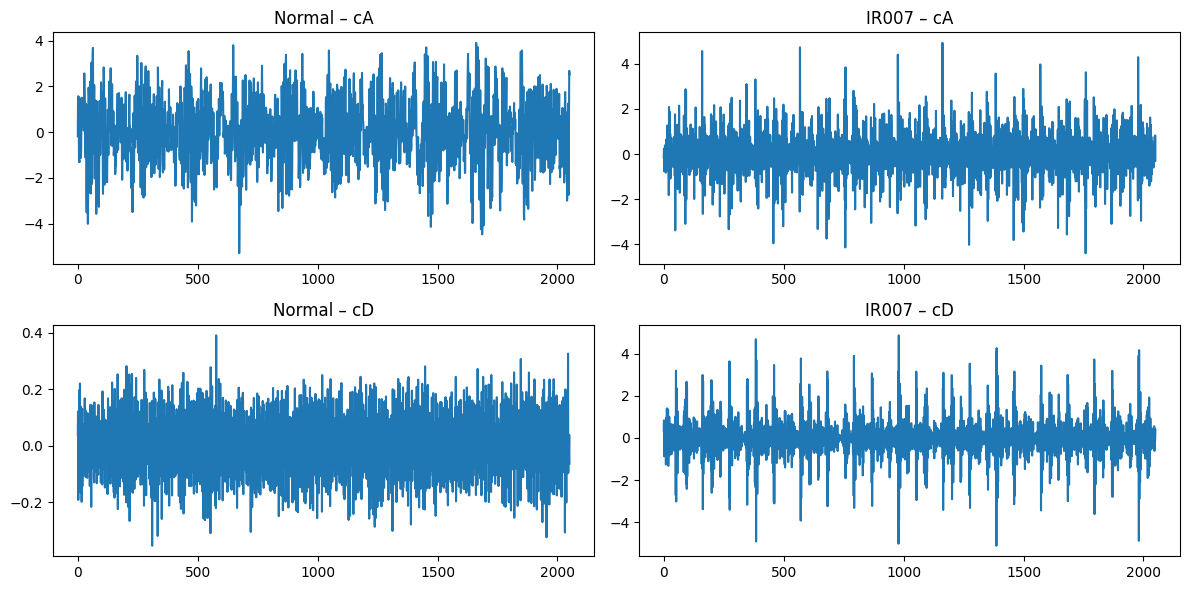

In [8]:
cA_N, cD_N = pywt.dwt(normal_signal, wavelet, mode=mode)
cA_I, cD_I = pywt.dwt(ir007_signal, wavelet, mode=mode)

# Visualization: cA and cD
plt.figure(figsize=(12,6))

plt.subplot(2,2,1)
plt.plot(cA_N)
plt.title('Normal – cA')

plt.subplot(2,2,2)
plt.plot(cA_I)
plt.title('IR007 – cA')

plt.subplot(2,2,3)
plt.plot(cD_N)
plt.title('Normal – cD')

plt.subplot(2,2,4)
plt.plot(cD_I)
plt.title('IR007 – cD')

plt.tight_layout()
plt.show()

## 7. Multi-level Decomposition

**Why multiple levels?**
- Fault information in rotating machinery appears at multiple frequency scales
- A single-level DWT separates only coarse low- and high-frequency components
- Multi-level decomposition enables progressive isolation of fault-related frequency bands

**How it works**
- A single-level DWT is first applied to the original signal
- The approximation coefficients (`cA`) are recursively decomposed
- Detail coefficients (`cD`) are stored at each level and represent different frequency bands
- The process stops at a predefined decomposition level selected by the user

**Interpretation of decomposition coefficients**
In a multi-level DWT with decomposition level L:

- `cD1` represents the highest-frequency detail components and captures impulsive events such as sudden bearing impacts.
- `cDk` (k = 2, 3, ..., L) represent progressively lower-frequency detail components, where fault harmonics and modulated vibration patterns may appear.
- `cAL` represents the lowest-frequency approximation after L levels of decomposition and reflects the global trend of the vibration signal rather than localized fault information.

As the decomposition level increases, the frequency bandwidth of each detail coefficient narrows, enabling finer separation of signal components across multiple scales.

> Note: Although a maximum allowable decomposition level exists based on signal length and wavelet filter length, the decomposition depth in this work is manually selected for interpretability and effectiveness.

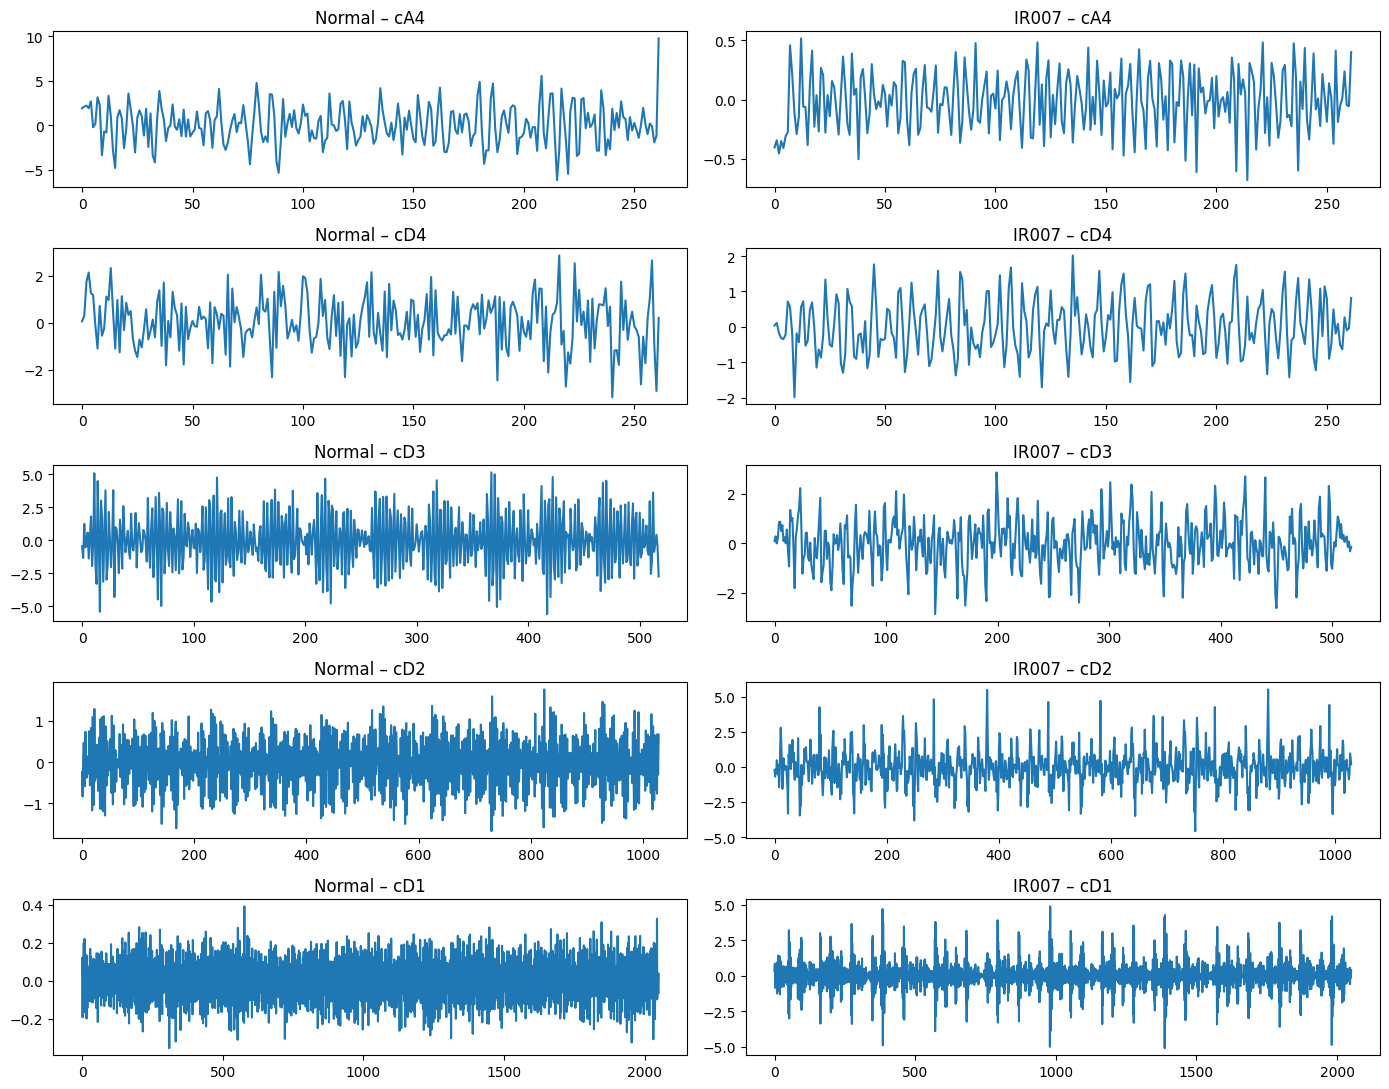

In [9]:
level = 4

L = level
coeffs_N = pywt.wavedec(normal_signal, wavelet, mode=mode, level=L)
coeffs_I = pywt.wavedec(ir007_signal,  wavelet, mode=mode, level=L)

# Dynamic labels based on decomposition level
labels = [f'cA{L}'] + [f'cD{k}' for k in range(L, 0, -1)]

plt.figure(figsize=(14, 2.2 * len(labels)))

for i, label in enumerate(labels):
    plt.subplot(len(labels), 2, 2*i + 1)
    plt.plot(coeffs_N[i])
    plt.title(f'Normal – {label}')

    plt.subplot(len(labels), 2, 2*i + 2)
    plt.plot(coeffs_I[i])
    plt.title(f'IR007 – {label}')

plt.tight_layout()
plt.show()

## 8. Quantitative

In [10]:
from scipy.stats import kurtosis

def dwt_features(coeffs):
    feats = {}
    for i, band in enumerate(coeffs[1:], 1):
        feats[f'cD{i}_energy'] = np.sum(band**2)
        feats[f'cD{i}_kurtosis'] = kurtosis(band)
    return feats

feat_N = dwt_features(coeffs_N)
feat_I = dwt_features(coeffs_I)

for k in feat_N:
    print(f"{k}: Normal={feat_N[k]:.2f}, IR007={feat_I[k]:.2f}")

cD1_energy: Normal=305.24, IR007=151.58
cD1_kurtosis: Normal=-0.06, IR007=-0.42
cD2_energy: Normal=2245.25, IR007=448.27
cD2_kurtosis: Normal=-0.43, IR007=0.40
cD3_energy: Normal=409.61, IR007=1526.02
cD3_kurtosis: Normal=-0.54, IR007=2.13
cD4_energy: Normal=26.49, IR007=1957.68
cD4_kurtosis: Normal=-0.48, IR007=4.22


## Flow Chart

In [21]:
from mermaid import Mermaid

Mermaid("""
graph TD
    %% Setup Phase
    Start([Original Signal]) --> Config[<b>Setup:</b><br/>Wavelet Selection &<br/>Boundary Padding]
    Config --> Loop{Decomposition<br/>Loop}

    %% Recursive Decomposition Logic
    Loop -->|Level i| Filters[High-Pass & Low-Pass Filters]
    Filters --> Down["Downsample (&downarrow;2)"]
    
    %% Branching the results
    Down --> Details([Detail Coefficients cDi])
    Down --> Approx[Approximation cAi]

    %% Feedback Loop
    Approx -->|i < 4| Loop
    Approx -->|i = 4| FinalApprox([Final Approx cA4])

    %% Final Output Collection
    Details -.-> Coll
    FinalApprox -.-> Coll
    
    Coll{{"Coefficient Collection<br/>[cA4, cD4, cD3, cD2, cD1]"}} --> Output([Feature Vector])

    %% Styling
    style Start fill:#f9f,stroke:#333
    style Details fill:#fff9c4,stroke:#fbc02d
    style FinalApprox fill:#c8e6c9,stroke:#2e7d32
    style Coll fill:#d1c4e9,stroke:#512da8
""")